# Multi Label Dataset Split with Stratification

In [1]:
import sys; print('Python:',sys.version)
import torch; print('Pytorch:',torch.__version__)
import fastai; print('Fastai:',fastai.__version__)

Python: 3.9.2 (default, Mar 16 2021, 09:09:15) 
[GCC 7.5.0]
Pytorch: 1.7.1
Fastai: 2.2.7


In [2]:
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from torchvision.utils import save_image
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import PIL 
import os

In [3]:
pathToDataSet = "/mnt/c/Users/tomsq/Documents/UnB/2020.2/TG/dataset_v1/"
path_anno = pathToDataSet + 'gt/'
path_img = pathToDataSet + 'done/'
get_y_fn = lambda x : path_anno + f'{x.stem}_GT.png'


label_fnames = get_image_files(path_anno)
fnames = get_image_files(path_img)
print(len(fnames), len(label_fnames))



508 508


## Generate DataSet Histogram

In [4]:
totalArray = []

for i in range(0,len(fnames)):
    img = Image.open(get_y_fn(fnames[i]))
    arr = np.asarray(img)
    totalArray += list(np.unique(arr,return_counts=False))

print('Array Generated')


Array Generated


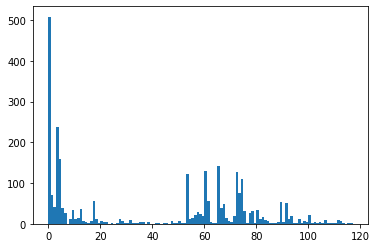

In [5]:
# histogram plot

codes = np.loadtxt( pathToDataSet + 'classesNumber.txt', dtype=str, delimiter='\n',encoding='utf') 
codes = [code.split(": ")[0] for code in codes] #pega apenas o ID de cada classe e ignora o nome

hist = plt.hist(totalArray, bins=len(codes), range=(0,len(codes)))
dicionario = {}


for code, contagem in zip(codes, hist[0]):
    dicionario[code] = int(contagem)

dicionario = {k: v for k, v in sorted(dicionario.items(), key=lambda item: item[1], reverse=True)} #sort



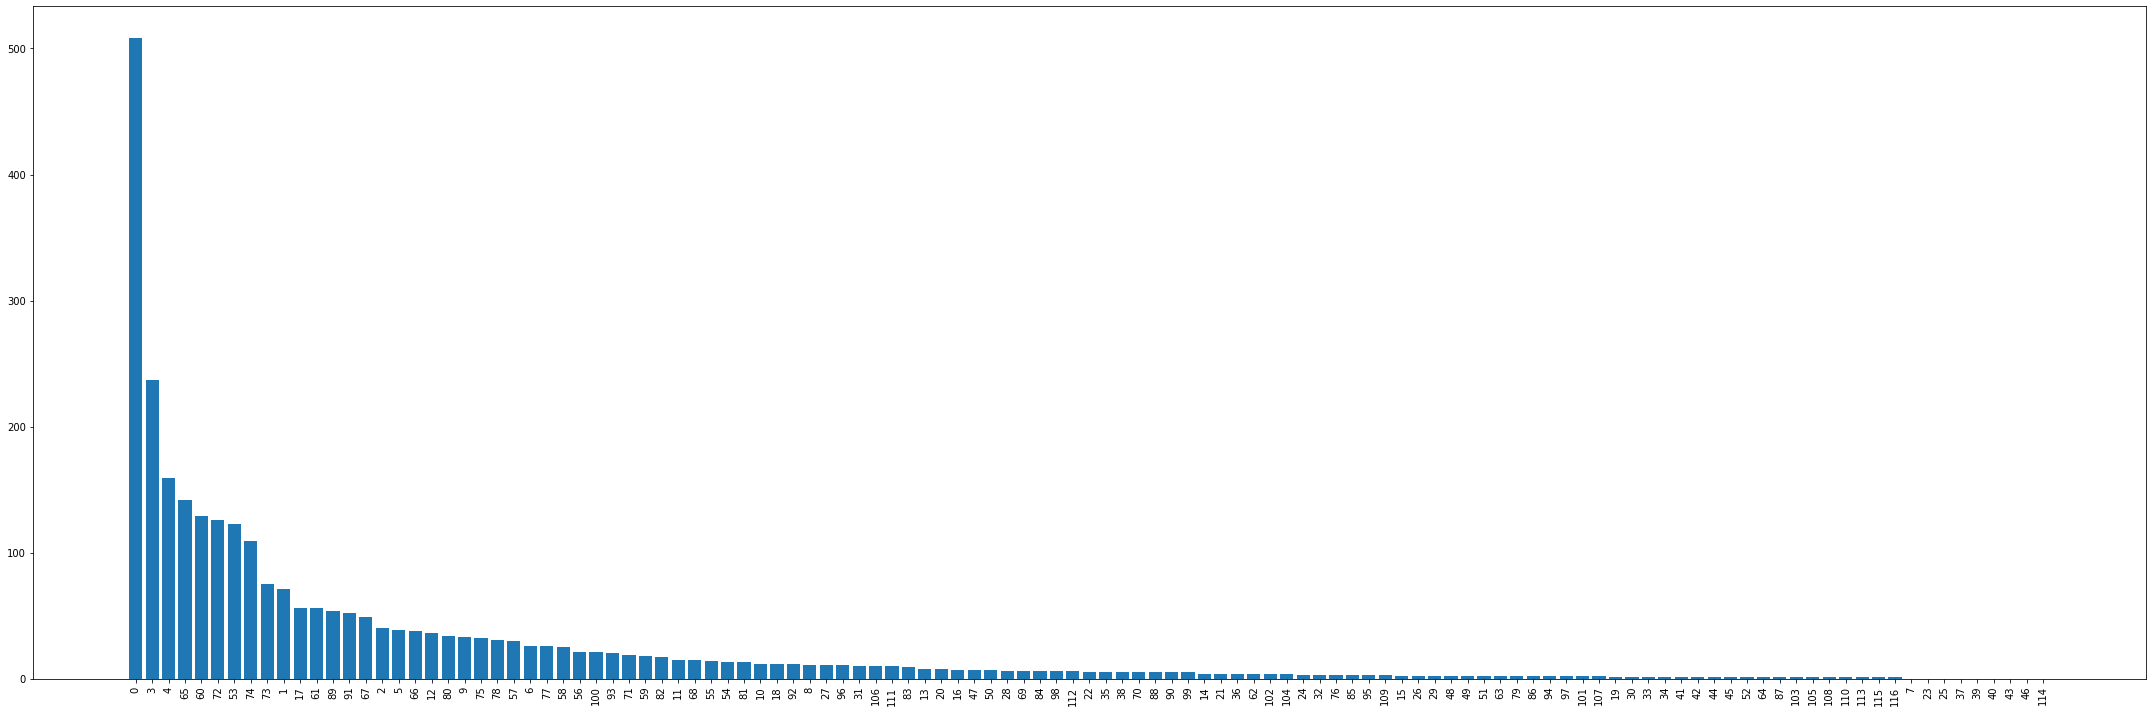

In [6]:
plt.figure(figsize=(30, 10))
plt.bar(*zip(*dicionario.items()))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [7]:
print('Class that most appears >>> ', list(dicionario.items())[1][0])
print('Appears >>> ', list(dicionario.items())[1][1], ' times')

Class that most appears >>>  3
Appears >>>  237  times


## Remove classes that appear less than a threshold

In [8]:
# get all ground truth images and label ids of each sample

allGTs = []
idsInGTs = []
for idx in range(0,len(fnames)):
    img = Image.open(get_y_fn(fnames[idx]))
    arr = np.asarray(img)
    idsInGTs.append(list(np.unique(arr,return_counts=False)))
    allGTs.append(arr)


In [9]:
def getImagesByClass(classId):
    imagesWithClass = []
    imagesIdx = []

    for i in range(0, len(fnames)):
        arr = allGTs[i]
        idsInGT = idsInGTs[i]
        if int(classId) in idsInGT:
            imagesWithClass.append(fnames[i])
            imagesIdx.append(i)
            

    return imagesWithClass, imagesIdx

In [10]:
# remove all images that has less than X samples

minClassAppearances = 3
idxsToRemove = []

for classId, classAppearances in dicionario.items():
    classImages, imagesIdx = getImagesByClass(classId)
    if classAppearances > 0 and len(imagesIdx) < minClassAppearances:
        idxsToRemove += imagesIdx
        print(classId,classImages,imagesIdx)

# remove repeated idxs
idxsToRemove = list(set(idxsToRemove))

fnamesManySamplesPerClass = [fnames[i] for i in range(0,len(fnames)) if i not in idxsToRemove]
label_fnamesManySamplesPerClass = [label_fnames[i] for i in range(0,len(label_fnames)) if i not in idxsToRemove]

len(fnamesManySamplesPerClass),len(label_fnamesManySamplesPerClass)

15 [Path('/mnt/c/Users/tomsq/Documents/UnB/2020.2/TG/dataset_v1/done/133.jpg'), Path('/mnt/c/Users/tomsq/Documents/UnB/2020.2/TG/dataset_v1/done/143.jpg')] [114, 125]
26 [Path('/mnt/c/Users/tomsq/Documents/UnB/2020.2/TG/dataset_v1/done/512.jpeg'), Path('/mnt/c/Users/tomsq/Documents/UnB/2020.2/TG/dataset_v1/done/513.jpeg')] [291, 292]
29 [Path('/mnt/c/Users/tomsq/Documents/UnB/2020.2/TG/dataset_v1/done/510.png'), Path('/mnt/c/Users/tomsq/Documents/UnB/2020.2/TG/dataset_v1/done/840.jpg')] [289, 457]
48 [Path('/mnt/c/Users/tomsq/Documents/UnB/2020.2/TG/dataset_v1/done/559.jpeg'), Path('/mnt/c/Users/tomsq/Documents/UnB/2020.2/TG/dataset_v1/done/561.jpeg')] [334, 336]
49 [Path('/mnt/c/Users/tomsq/Documents/UnB/2020.2/TG/dataset_v1/done/143.jpg'), Path('/mnt/c/Users/tomsq/Documents/UnB/2020.2/TG/dataset_v1/done/504.png')] [125, 284]
51 [Path('/mnt/c/Users/tomsq/Documents/UnB/2020.2/TG/dataset_v1/done/532.jpeg'), Path('/mnt/c/Users/tomsq/Documents/UnB/2020.2/TG/dataset_v1/done/554.jpeg')] [31

(469, 469)

## Split dataset

In [11]:
# get ids and images from all ground truths filtered in the last step!!!

idsInGTs = []
allGTs = []
for i in range(0,len(fnamesManySamplesPerClass)):
    img = Image.open(get_y_fn(fnamesManySamplesPerClass[i]))
    arr = np.asarray(img)
    idsInGTs.append(list(np.unique(arr,return_counts=False)))
    allGTs.append(arr)

In [12]:
def getImagesByClass(classId):
    imagesWithClass = []
    imagesIdx = []

    for i in range(0, len(fnamesManySamplesPerClass)):
        arr = allGTs[i]
        idsInGT = idsInGTs[i]
        if int(classId) in idsInGT:
            imagesWithClass.append(fnamesManySamplesPerClass[i])
            imagesIdx.append(i)
            

    return imagesWithClass, imagesIdx

In [13]:
# split multi label dataset with stratification: start from the classes with less appearances
# the testset size is not exactly as expected because it is difficult to split based on multi label ids. The results are close to the expected percentage

from sklearn.model_selection import train_test_split

trainIdxs = []
testIdxs = []
testsize = 0.2

dicionario = {k: v for k, v in sorted(dicionario.items(), key=lambda item: item[1], reverse=False)} # reverse dict order (ascendent order)
for classId, classAppearances in dicionario.items():
    classImages, imagesIdx = getImagesByClass(classId)
    if len(imagesIdx) > 0:
        classTrain_idxs, classTest_idxs, _, _ = train_test_split(imagesIdx,imagesIdx, test_size=testsize, random_state=2)
        testIdxs += [idx for idx in classTest_idxs if idx not in testIdxs and idx not in trainIdxs]
        trainIdxs += [idx for idx in classTrain_idxs if idx not in testIdxs and idx not in trainIdxs]
        #print(classId, classAppearances, imagesIdx, classTrain_idxs, classTest_idxs)

len(trainIdxs), len(testIdxs)

(362, 107)

In [14]:

train_fnames = list(np.array(fnamesManySamplesPerClass)[trainIdxs])
test_fnames = list(np.array(fnamesManySamplesPerClass)[testIdxs])

len(train_fnames), len(test_fnames)

(362, 107)

## Check stratification by plotting histograms for each dataset

### Testset

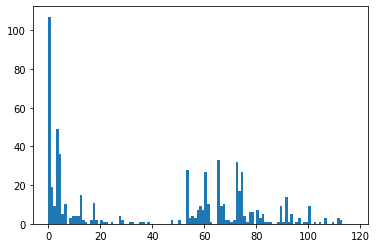

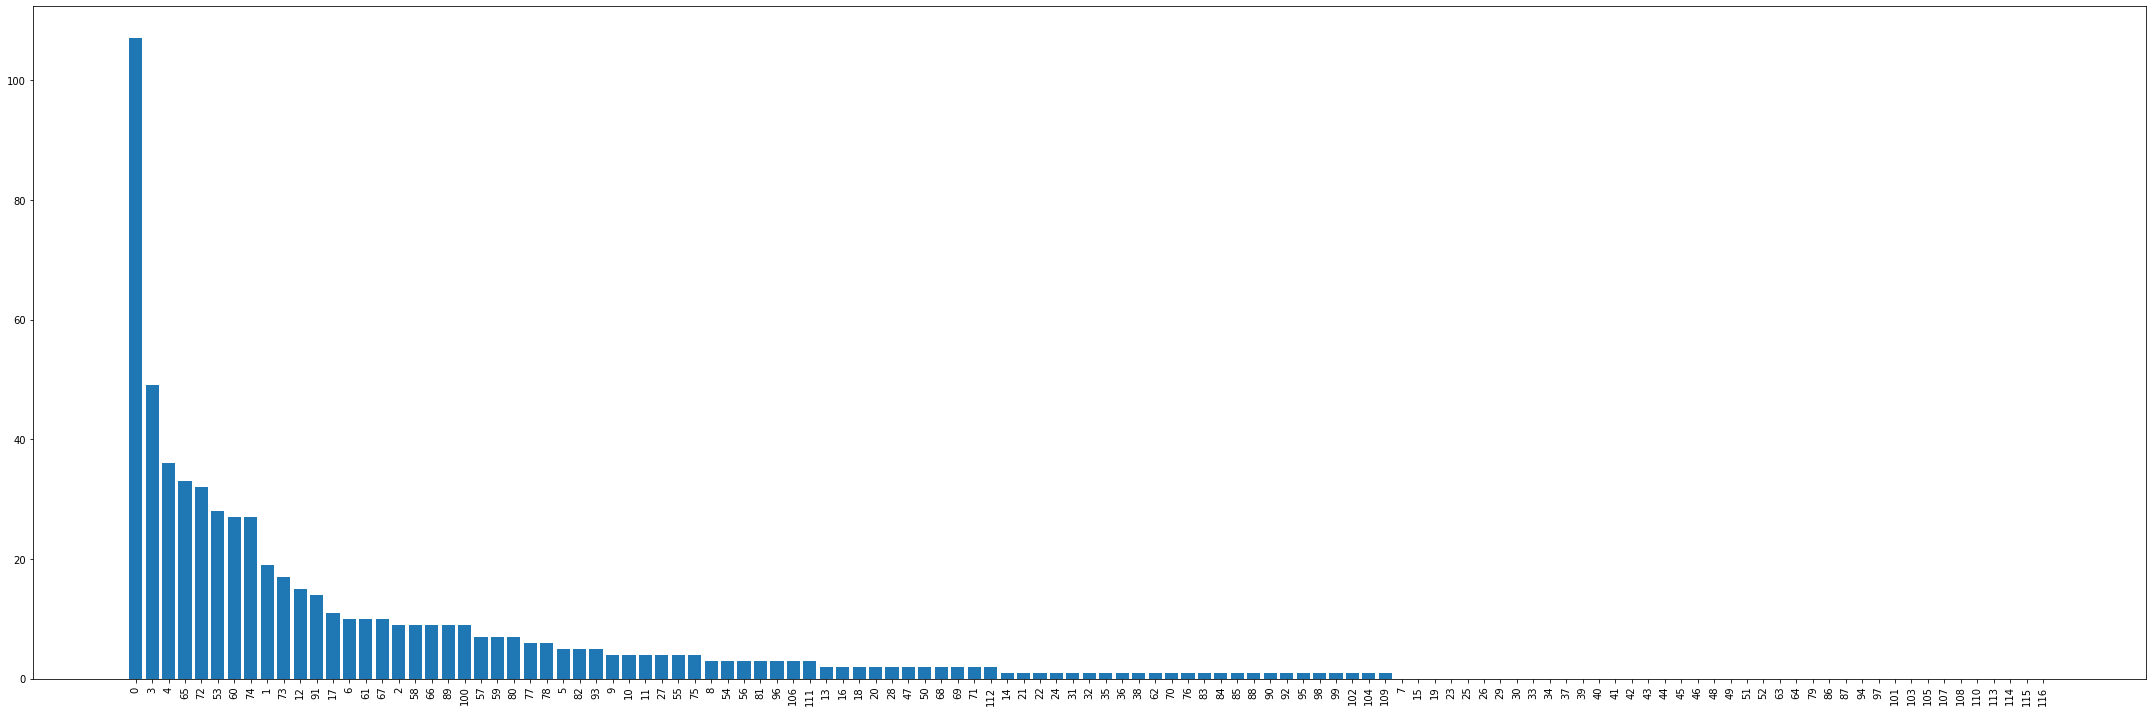

In [15]:
totalArray = []

for i in range(0,len(test_fnames)):
    img = Image.open(get_y_fn(test_fnames[i]))
    arr = np.asarray(img)
    totalArray += list(np.unique(arr,return_counts=False))

codes = np.loadtxt( pathToDataSet + 'classesNumber.txt', dtype=str, delimiter='\n',encoding='utf') 
codes = [code.split(": ")[0] for code in codes] #pega apenas o ID de cada classe e ignora o nome

hist = plt.hist(totalArray, bins=len(codes), range=(0,len(codes)))
dicionarioTestset = {}


for code, contagem in zip(codes, hist[0]):
    dicionarioTestset[code] = int(contagem)

dicionarioTestset = {k: v for k, v in sorted(dicionarioTestset.items(), key=lambda item: item[1], reverse=True)} #sort

plt.figure(figsize=(30, 10))
plt.bar(*zip(*dicionarioTestset.items()))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [16]:
# check how many classes have zero samples

testsetNullClasses = []
for classId, classAppearances in dicionarioTestset.items():
    if classAppearances == 0:
        testsetNullClasses.append(classId)
        #print(classId,classAppearances)

print('Class that most appears >>> ', list(dicionarioTestset.items())[1][0])
print('Appears >>> ', list(dicionarioTestset.items())[1][1], ' times')

Class that most appears >>>  3
Appears >>>  49  times


### Trainset

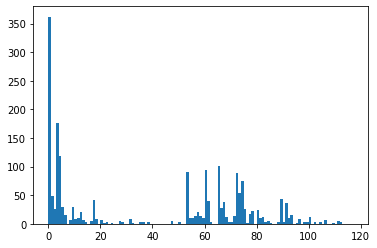

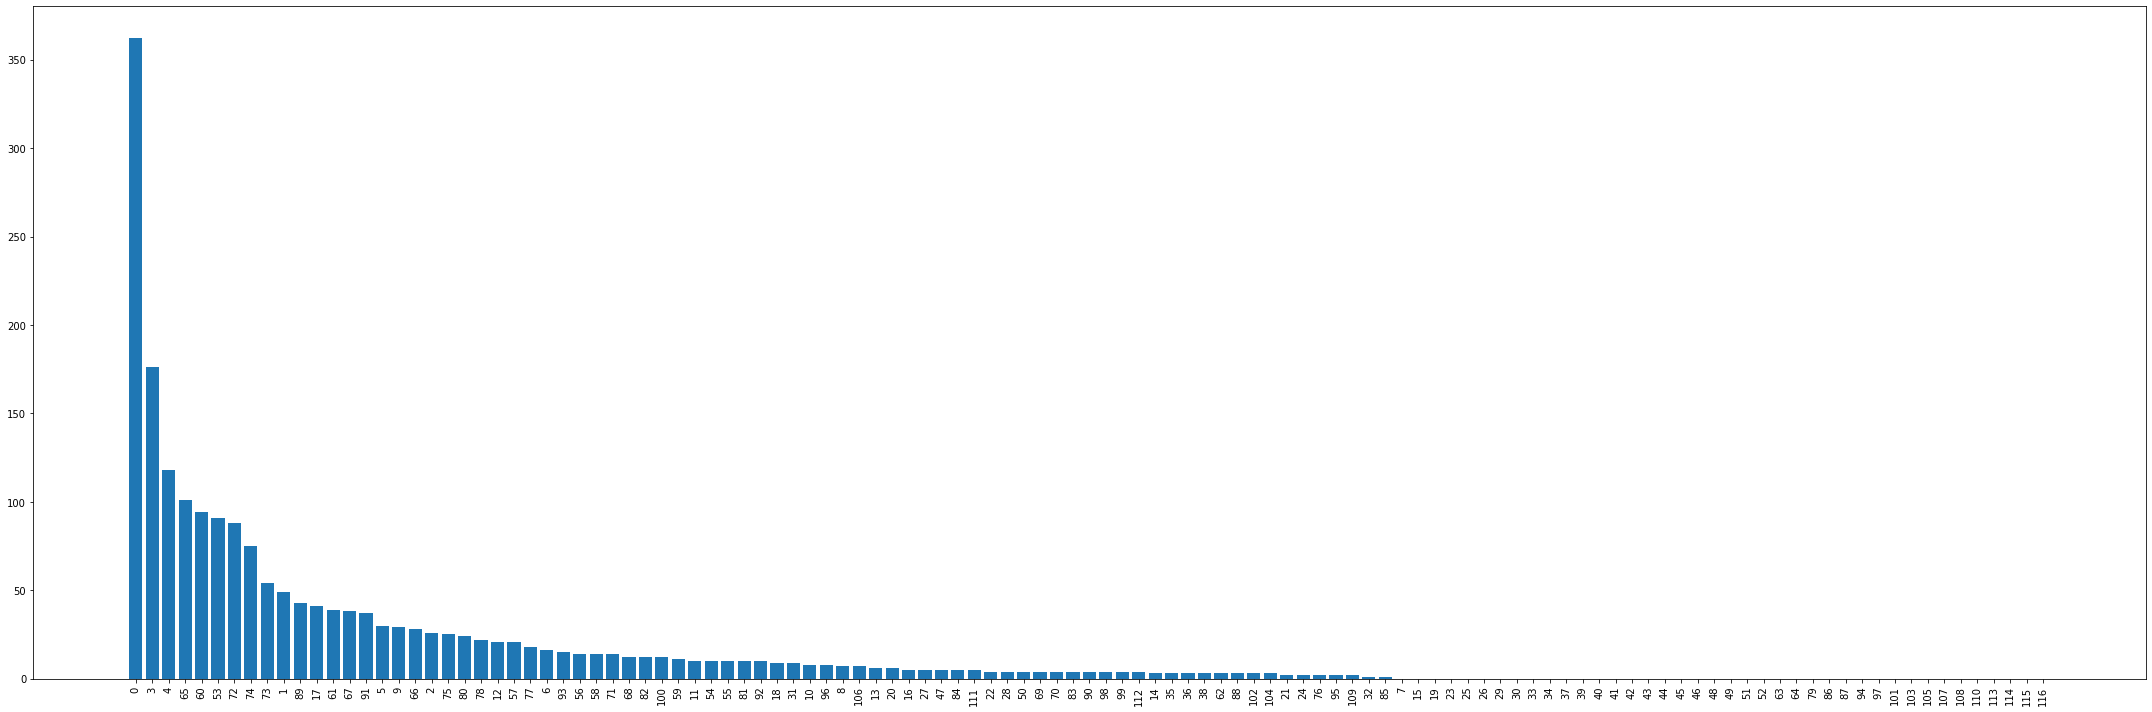

In [17]:
totalArray = []

for i in range(0,len(train_fnames)):
    img = Image.open(get_y_fn(train_fnames[i]))
    arr = np.asarray(img)
    totalArray += list(np.unique(arr,return_counts=False))

codes = np.loadtxt( pathToDataSet + 'classesNumber.txt', dtype=str, delimiter='\n',encoding='utf') 
codes = [code.split(": ")[0] for code in codes] #pega apenas o ID de cada classe e ignora o nome

hist = plt.hist(totalArray, bins=len(codes), range=(0,len(codes)))
dicionarioTrainset = {}


for code, contagem in zip(codes, hist[0]):
    dicionarioTrainset[code] = int(contagem)

dicionarioTrainset = {k: v for k, v in sorted(dicionarioTrainset.items(), key=lambda item: item[1], reverse=True)} #sort

plt.figure(figsize=(30, 10))
plt.bar(*zip(*dicionarioTrainset.items()))
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [18]:
# check how many classes have zero samples

trainsetNullClasses = []
for classId, classAppearances in dicionarioTrainset.items():
    if classAppearances == 0:
        trainsetNullClasses.append(classId)
        #print(classId,classAppearances)

print('Class that most appears >>> ', list(dicionarioTrainset.items())[1][0])
print('Appears >>> ', list(dicionarioTrainset.items())[1][1], ' times')

Class that most appears >>>  3
Appears >>>  176  times


In [19]:
# this comparison should be true and their lengths equal

(trainsetNullClasses == testsetNullClasses), len(trainsetNullClasses), len(testsetNullClasses)


(True, 40, 40)

In [20]:
# compare test/train ratio for each class

for classId, classAppearances in dicionarioTrainset.items():
    if classAppearances > 0:
        testClassAppearances = dicionarioTestset[classId]
        print(classId, testClassAppearances/(testClassAppearances+classAppearances))
        if testClassAppearances/(testClassAppearances+classAppearances) <= 0.1:
            print("^^^^^^^^^Few samples in testset^^^^^^^^^")

0 0.2281449893390192
3 0.21777777777777776
4 0.23376623376623376
65 0.2462686567164179
60 0.2231404958677686
53 0.23529411764705882
72 0.26666666666666666
74 0.2647058823529412
73 0.23943661971830985
1 0.27941176470588236
89 0.17307692307692307
17 0.21153846153846154
61 0.20408163265306123
67 0.20833333333333334
91 0.27450980392156865
5 0.14285714285714285
9 0.12121212121212122
66 0.24324324324324326
2 0.2571428571428571
75 0.13793103448275862
80 0.22580645161290322
78 0.21428571428571427
12 0.4166666666666667
57 0.25
77 0.25
6 0.38461538461538464
93 0.25
56 0.17647058823529413
58 0.391304347826087
71 0.125
68 0.14285714285714285
82 0.29411764705882354
100 0.42857142857142855
59 0.3888888888888889
11 0.2857142857142857
54 0.23076923076923078
55 0.2857142857142857
81 0.23076923076923078
92 0.09090909090909091
^^^^^^^^^Few samples in testset^^^^^^^^^
18 0.18181818181818182
31 0.1
^^^^^^^^^Few samples in testset^^^^^^^^^
10 0.3333333333333333
96 0.2727272727272727
8 0.3
106 0.3
13 0.25
20

## Export train and test sets with pickle

In [21]:
trainFilenames = [file.name for file in train_fnames]
testFilenames = [file.name for file in test_fnames] 
trainFilenames[0], testFilenames[0]

('459.jpeg', '511.jpeg')

In [22]:
# dump arrays into pickle file

with open('var/trainFilenames.pkl', 'wb') as f:
  pickle.dump(trainFilenames, f)
with open('var/testFilenames.pkl', 'wb') as f:
  pickle.dump(testFilenames, f)

In [23]:
# load arrays from pickle file

with open('var/trainFilenames.pkl', 'rb') as f:
  trainFiles = pickle.load(f)
with open('var/testFilenames.pkl', 'rb') as f:
  testFiles = pickle.load(f)